In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/Shareddrives/CSCI 461/processed'
#%ls processed/*


Mounted at /content/drive/
/content/drive/Shareddrives/CSCI 461/processed


# DATA MANIPULATION

In [ ]:
# Importing the data

data = pd.read_csv("combined_ohe.csv")
#data.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
#print(data.head())

In [ ]:
edu_matrix = data[["highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license"]]
data["edu_categorical"] = edu_matrix.idxmax(axis=1)

In [ ]:
# making education binary

educationBinary = \
{   
    "highedcert_associate degree": 1,
    "highedcert_bachelor degree": 1,
    "highedcert_high school or ged": 1,
    "highedcert_higher degree": 1,
    "highedcert_none of the above":0,
    "highedcert_vocational certificate": 1,
    "highedcert_vocational license": 1
}
data['edu_binary'] = data["edu_categorical"].map(educationBinary) 

In [ ]:
# dropping overlap variables (and other outcome features, recnumbr)

#edu
data.drop(columns=["recnumbr", "highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license","edu_categorical", 'homeless_no','homeless_yes','subabuse_no',
                   'subabuse_yes', 'incarc_no', 'incarc_yes', 'edu_categorical'], axis=1, inplace=True)

#subabuse
# data.drop(columns=["recnumbr", "highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
#                   "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
#                   "highedcert_vocational license","edu_categorical", 'edu_binary','homeless_no','homeless_yes', 'subabuse_no', 'incarc_no', 'incarc_yes', 'edu_categorical'], axis=1, inplace=True)
#data.nunique()

In [ ]:
# filtering for age 19+ and balancing the class
data = data[data['age']>18].sort_values('age', ascending = False).sort_values('edu_binary').iloc[:1084*2,:]

target='edu_binary'

# #subabuse
# #data = data[data['age']>18].sort_values('age', ascending = False).sort_values(target)

# #filter 17

# data = data[data['age']==17].sort_values(target, ascending=False).iloc[:5980*2,:]
# data.drop(columns=["age"], inplace=True)


## SETTING UP MODELS

In [ ]:
# Setting target variables
data = data.sample(frac=1)
y = data.loc[:,target]
X = data.loc[:,data.columns != target]


In [ ]:
#  TEST & TRAIN SPLIT
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,) # check the shape of X_train and X_test

# Feature scaling 
# scaler = MinMaxScaler((-1,1))
# X['age'] = scaler.fit_transform(np.array(X['age']).reshape(-1, 1))
y = data.loc[:,target]
X = data.loc[:,data.columns != target]
X=X.reset_index()

In [ ]:
# Prep to cross validate

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# Folds for cross-val
k = 5

In [ ]:
# Functions to print CM heat map and performnce results

from sklearn.metrics import confusion_matrix
#from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
#import sklearn
import seaborn as sns

def my_cm(y,y_pred,k=5):

  cm = confusion_matrix(y, y_pred)
  cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
  return sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

def my_cm_dec(y,y_pred,k=5):

  cm = confusion_matrix(y, y_pred)
  cm_matrix = pd.DataFrame(data=cm/y.shape[0], columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
  return sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu')

def my_scores(mod, X, y,k=5):
  scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
  scores = cross_validate(mod, X, y, cv=k,scoring=scoring)
  print("accuracy:",sum(scores["test_accuracy"])/k)
  print("precision:",sum(scores["test_precision"])/k)
  print("auc:",sum(scores["test_roc_auc"])/k)
  print("recall:",sum(scores["test_recall"])/k)
  print("f1:",sum(scores["test_f1"])/k)
  return  

## SVM

TIME: 0.04476265459999998 min


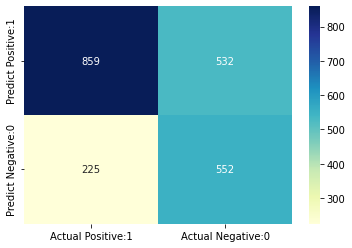

Breakdown by Sex


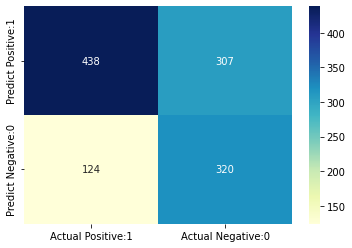

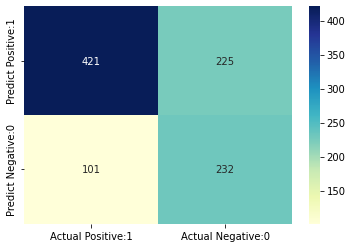

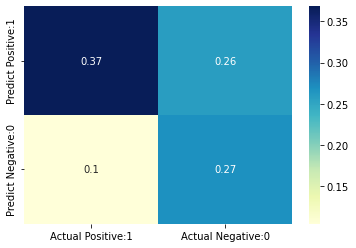

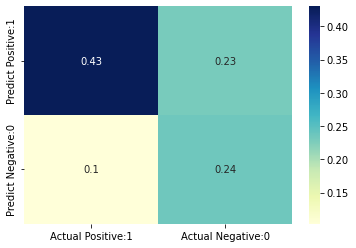

Breakdown by amiakn


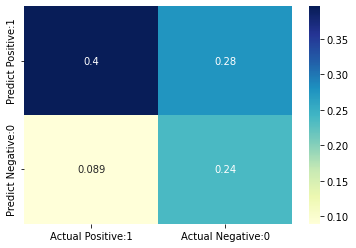

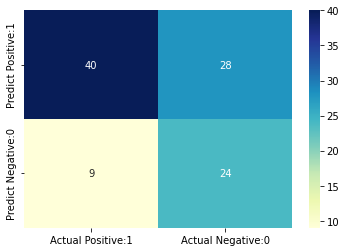

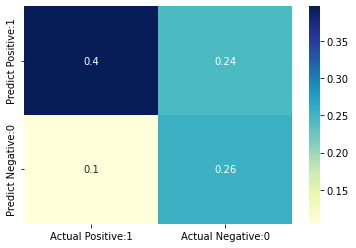

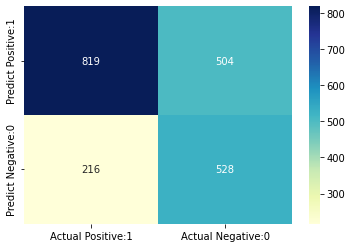

Breakdown by asian


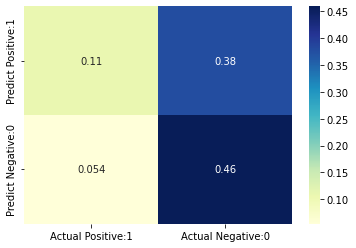

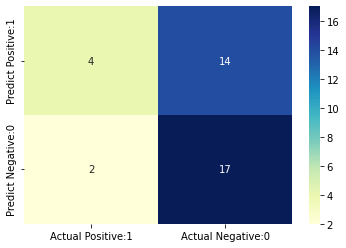

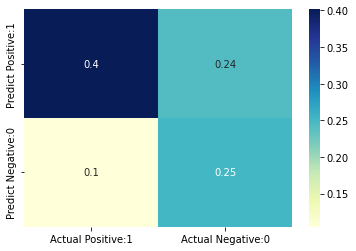

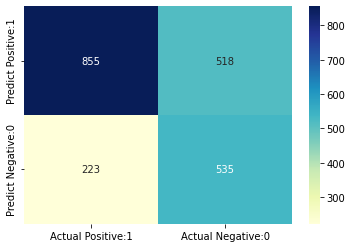

Breakdown by blkafram


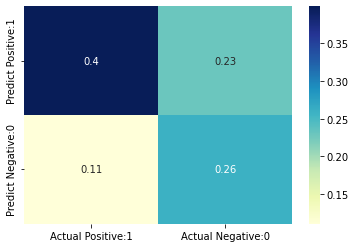

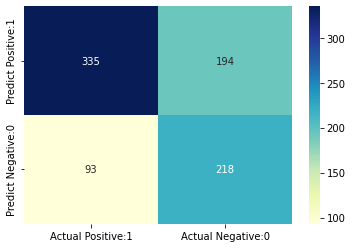

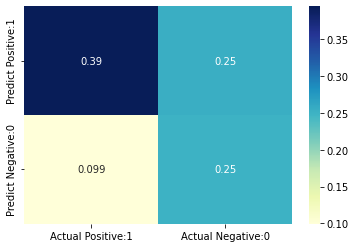

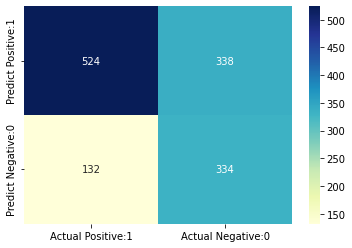

Breakdown by hawaiipi


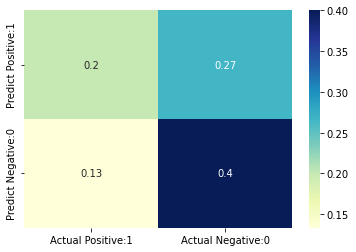

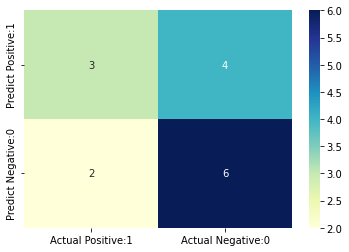

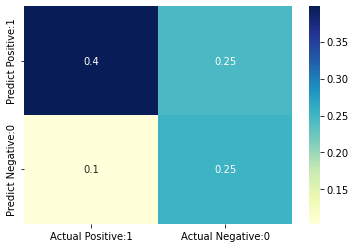

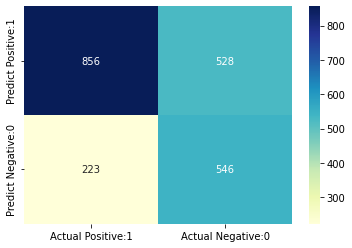

Breakdown by white


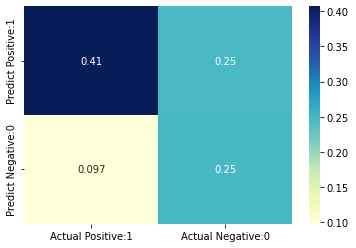

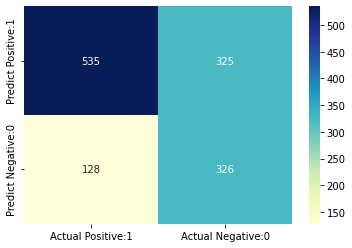

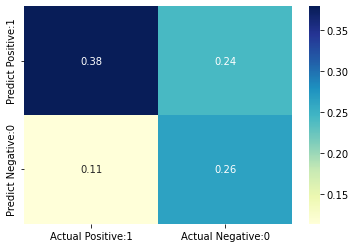

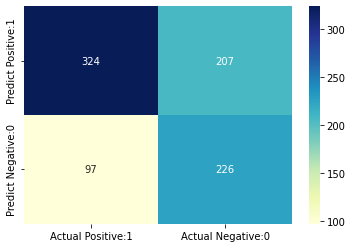

Breakdown by raceunkn


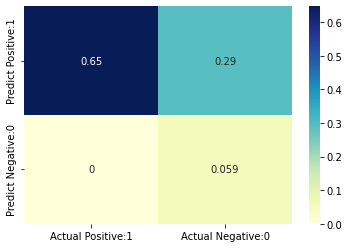

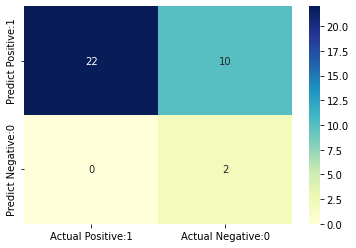

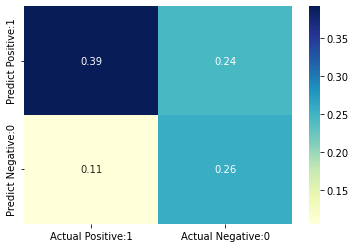

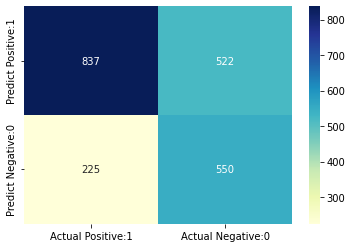

Breakdown by hisorgin


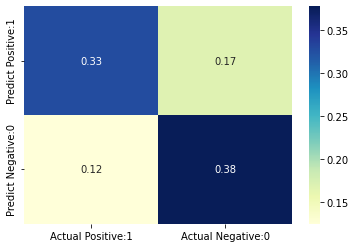

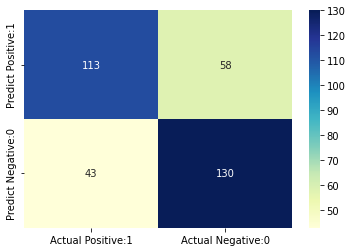

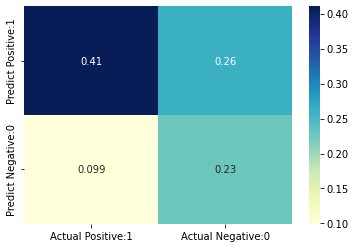

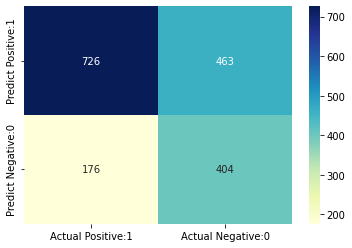

In [ ]:
# import SVC classifier
from sklearn.svm import SVC

# instantiate classifier with default hyperparameters
svc=SVC() 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(svc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm(y_pred,y)
plt.show()
print("Breakdown by Sex")
my_cm(y_pred[X.index[X['sex_female'] == True].tolist()],y.iloc[X.index[X['sex_female'] == True].tolist()].values)
plt.show()
my_cm(y_pred[X.index[X['sex_male'] == True].tolist()],y.iloc[X.index[X['sex_male'] == True].tolist()].values)
plt.show()
my_cm_dec(y_pred[X.index[X['sex_female'] == True].tolist()],y.iloc[X.index[X['sex_female'] == True].tolist()].values)
plt.show()
my_cm_dec(y_pred[X.index[X['sex_male'] == True].tolist()],y.iloc[X.index[X['sex_male'] == True].tolist()].values)
plt.show()

for i in ['amiakn','asian', 'blkafram', 'hawaiipi', 'white','raceunkn', 'hisorgin']:
  print("Breakdown by {}".format(i))
  my_cm_dec(y_pred[X.index[X[i+'_yes'] == True].tolist()],y.iloc[X.index[X[i+'_yes']==True].tolist()].values)
  plt.show()
  my_cm(y_pred[X.index[X[i+'_yes'] == True].tolist()],y.iloc[X.index[X[i+'_yes']==True].tolist()].values)
  plt.show()
  my_cm_dec(y_pred[X.index[X[i+'_no'] == True].tolist()],y.iloc[X.index[X[i+'_no'] == True].tolist()].values)
  plt.show()
  my_cm(y_pred[X.index[X[i+'_no'] == True].tolist()],y.iloc[X.index[X[i+'_no'] == True].tolist()].values)
  plt.show()

In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(svc,X,y) 
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

accuracy: 0.7393940038952331
precision: 0.7892728473095121
auc: 0.817545833225185
recall: 0.6549795186891961
f1: 0.7151251551015002
TIME: 0.03853423496666674 min


## Random Forest Classifier

TIME: 0.0659598914 min


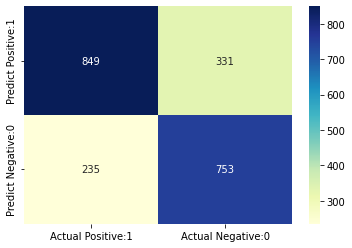

In [ ]:
# import RF classifier
from sklearn.ensemble import RandomForestClassifier

# instantiate classifier with default hyperparameters
rfc=RandomForestClassifier() 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(rfc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm(y_pred,y)


In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(rfc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

accuracy: 0.732001575121593
precision: 0.7563037090928216
auc: 0.8256253721282709
recall: 0.6845024748250554
f1: 0.7180752081889316
TIME: 0.042402258849999916 min


## Gradient Boosting Classifier

TIME: 0.045190661733333096 min


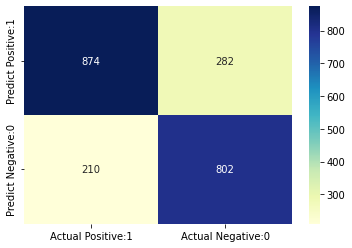

In [ ]:
# import GBT classifier
from sklearn.ensemble import GradientBoostingClassifier

# instantiate classifier with default hyperparameters
gbc=GradientBoostingClassifier() 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(gbc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm(y_pred,y)


In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(gbc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

accuracy: 0.7730505209608242
precision: 0.790996202676875
auc: 0.865368248698485
recall: 0.7425883256528418
f1: 0.7654120328102209
TIME: 0.04657966866666688 min


## Logistic Regression

TIME: 0.010468427100000118 min


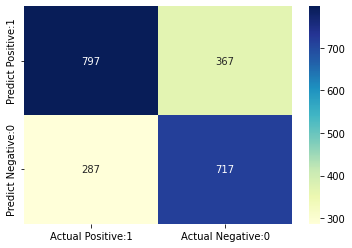

In [ ]:
# import log classifier
from sklearn.linear_model import LogisticRegressionCV

# instantiate classifier with default hyperparameters
lrc=LogisticRegressionCV(Cs=1) 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(lrc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm(y_pred,y)

In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(lrc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

accuracy: 0.6983493151413884
precision: 0.7149507894472047
auc: 0.7633522966360784
recall: 0.66147380098993
f1: 0.6861299128092554
TIME: 0.01153003886666634 min


## XGBoost (Imbeded Feature Selection)

TIME: 0.05623600686666634 min


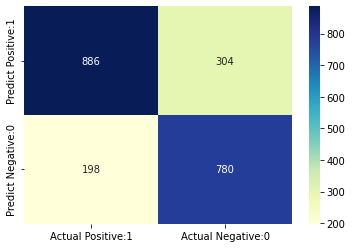

In [ ]:
# import log classifier
from xgboost import XGBClassifier

# instantiate classifier with default hyperparameters
xgbc=XGBClassifier()

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(xgbc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm(y_pred,y)

In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(xgbc,X,y) # 0.02 increase in precision over gbc
end = time.perf_counter()
print("TIME:",(end-start)/60,"min") 

accuracy: 0.7684347761305224
precision: 0.7975967228825571
auc: 0.8616308715647202
recall: 0.7195383171189623
f1: 0.7560714783238877
TIME: 0.04534026941666648 min
